## POS tagging using Viterbi

In [48]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import pprint, time

In [49]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
# reading the Treebank tagged sentences
data = list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [51]:
# let's check some of the tagged data
print(data[:10])

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [52]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(data, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Testing Set Length -", len(test_set))
print("-" * 100)
print("Training Data -\n")
print(train_set[:10])

Training Set Length - 54473
Testing Set Length - 2867
----------------------------------------------------------------------------------------------------
Training Data -

[[('I', 'PRON'), ('was', 'VERB'), ('held', 'VERB'), ('up', 'PRT'), ('a', 'DET'), ('bit', 'NOUN'), ('trying', 'VERB'), ('to', 'PRT'), ('make', 'VERB'), ('a', 'DET'), ('left', 'ADJ'), ('turn', 'NOUN'), ('.', '.')], [('The', 'DET'), ('trials', 'NOUN'), ('are', 'VERB'), ('independent', 'ADJ'), ('.', '.')], [('Furthermore', 'ADV'), ('I', 'PRON'), ('can', 'VERB'), ('identify', 'VERB'), ('each', 'DET'), ('design', 'NOUN'), ('.', '.')], [('Hoping', 'VERB'), ('to', 'PRT'), ('cut', 'VERB'), ('down', 'PRT'), ('on', 'ADP'), ('such', 'ADJ'), ('works', 'NOUN'), (',', '.'), ('Udall', 'NOUN'), ('had', 'VERB'), ('proposed', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('politician', 'NOUN'), ('be', 'VERB'), ('at', 'ADP'), ('least', 'ADJ'), ('fifty', 'NUM'), ('years', 'NOUN'), ('departed', 'VERB'), ('before', 'ADP'), ('he', 'PRON'), ('is',

In [53]:
# Getting list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Train Tagged Words - ", len(train_tagged_words))

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Train Tagged Words - ", len(test_tagged_words))

Train Tagged Words -  1103840
Train Tagged Words -  57352


In [54]:
# Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('I', 'PRON'),
 ('was', 'VERB'),
 ('held', 'VERB'),
 ('up', 'PRT'),
 ('a', 'DET'),
 ('bit', 'NOUN'),
 ('trying', 'VERB'),
 ('to', 'PRT'),
 ('make', 'VERB'),
 ('a', 'DET')]

In [55]:
# tokens in the train set - train_tagged_words
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['I', 'was', 'held', 'up', 'a', 'bit', 'trying', 'to', 'make', 'a']

In [56]:
# POS tags for the tokens in the train set - train_tagged_words

train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:10]

['PRON', 'VERB', 'VERB', 'PRT', 'DET', 'NOUN', 'VERB', 'PRT', 'VERB', 'DET']

In [57]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)

In [58]:
# building the POS tags to a set
training_pos_tag_set = set(train_tagged_pos_tokens)

In [59]:
# let's check how many unique tags are present in training data
print(len(training_pos_tag_set))

12


In [60]:
# let's check how many words are present in vocabulary
print(len(training_vocabulary_set))

54763


### Build the vanilla Viterbi based POS tagger

#### Function to compute emission probabilties for a given word

In [61]:
# compute emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)    
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]    
    word_given_tag_count = len(word_given_tag_list)    
    
    return (word_given_tag_count, tag_count)

#### Function to compute transition probabilties for a given tag and previous tag

In [62]:
# compute transition probabilities of a previous and next tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags_list = [tag for tag in tags if tag == t1]
    t1_tags_count = len(t1_tags_list)
    
    t2_given_t1_list = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    t2_given_t1_count = len(t2_given_t1_list)
    
    return(t2_given_t1_count, t1_tags_count)

In [63]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

In [64]:
# creating t x t transition matrix of training_pos_tag_set
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [65]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [66]:
tags_df.to_csv("tags_df.csv")

In [67]:
# Let's have a glimpse into the transition matrix
tags_df

,PRT,X,NOUN,ADJ,.,ADP,ADV,NUM,VERB,PRON,CONJ,DET
PRT,0.011016,0.000071,0.035978,0.018960,0.076828,0.090739,0.036225,0.005084,0.623274,0.006638,0.011969,0.083219
X,0.006792,0.507925,0.054340,0.002264,0.279245,0.053585,0.007547,0.000755,0.052830,0.006792,0.023396,0.004528
NOUN,0.018005,0.000340,0.149926,0.012906,0.283717,0.244557,0.026640,0.008092,0.159083,0.020441,0.060028,0.016265
ADJ,0.019146,0.000478,0.652704,0.056948,0.100319,0.088527,0.009743,0.006977,0.017700,0.003897,0.037651,0.005909
.,0.032142,0.001484,0.136466,0.041851,0.140953,0.112298,0.078637,0.018575,0.093645,0.106984,0.087981,0.148977
ADP,0.014202,0.000479,0.258708,0.082478,0.009698,0.020354,0.015582,0.030139,0.041203,0.069715,0.001903,0.455539
ADV,0.028790,0.000093,0.032934,0.136424,0.169526,0.142212,0.096712,0.013331,0.240679,0.048263,0.017382,0.073654
NUM,0.005788,0.000212,0.382482,0.058936,0.271174,0.130999,0.020539,0.021669,0.046019,0.009176,0.038961,0.014046
VERB,0.065542,0.000184,0.097473,0.057537,0.080719,0.169283,0.103793,0.009047,0.184242,0.055200,0.014394,0.162584
PRON,0.023840,0.000021,0.008743,0.009638,0.103612,0.055975,0.053864,0.001002,0.705902,0.008402,0.011344,0.017656


### Exploratory Data Analysis

In [68]:
# Importing libraries for heatmap
import matplotlib.pyplot as plt
import seaborn as sns

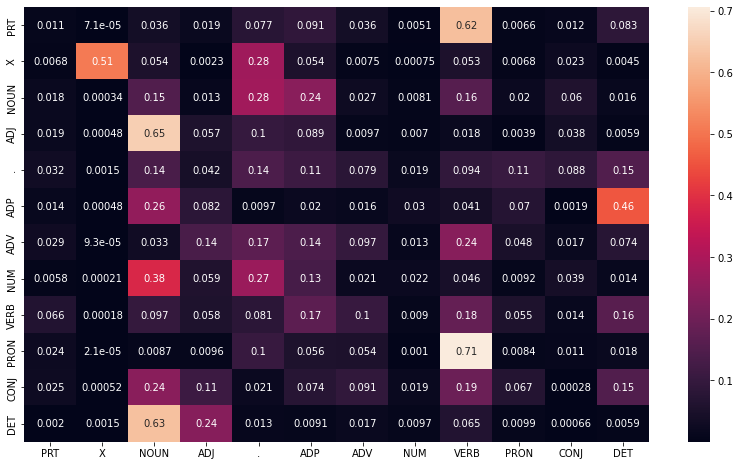

In [69]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

### Viterbi Algorithm

The steps are as follows:

1. Given a sequence of words.
2. iterate through the sequence
3. for each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. assign the tag which has maximum probability obtained in step 3 above.
5. move to the next word in sequence to repeat steps 3 and 4 above.

In [70]:
tags_df.loc['.']

PRT     0.032142
X       0.001484
NOUN    0.136466
ADJ     0.041851
.       0.140953
ADP     0.112298
ADV     0.078637
NUM     0.018575
VERB    0.093645
PRON    0.106984
CONJ    0.087981
DET     0.148977
Name: ., dtype: float32

In [71]:
# Vanilla Viterbi Algorithm
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag] #initial probability for all tags
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1] #probabilit of a word given a sentence
            state_probability = emission_p * transition_p    #probability of a given state(words and its tags)
            p.append(state_probability) #append all the probabilities
            
        pmax = max(p) #select the max probability of that state
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [72]:
print(word_given_tag("IT","X")[0]/word_given_tag("IT","X")[1])

0.0


In [73]:
# T = list(set([pair[1] for pair in train_tagged_words]))
# emissions = []
# results = []
# for key, word in enumerate(test_tagged_words):
#   for tag in T:
#     emission_p = word_given_tag(test_tagged_words[key], tag)[0]/word_given_tag(test_tagged_words[key], tag)[1]
#     emissions.append(emission_p)
#   results.append(emissions)

### Testing Vanilla Viterbi Algorithm on sampled test data

In [74]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1, len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [75]:
# tagging the test sentences

tagged_seq = Vanilla_Viterbi(test_tagged_words)

# accuracy
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check)/len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Vanilla Viterbi Algorithm Accuracy:  94.73684210526315


In [76]:
tagged_seq

[('She', 'PRON'),
 ('was', 'VERB'),
 ('limp', 'ADJ'),
 ('and', 'CONJ'),
 ('beaten', 'VERB'),
 ('from', 'ADP'),
 ('her', 'DET'),
 ('loss', 'NOUN'),
 (';', '.'),
 (';', '.'),
 ('He', 'PRON'),
 ('raised', 'VERB'),
 ('the', 'DET'),
 ('Winchester', 'NOUN'),
 ('and', 'CONJ'),
 ('pointed', 'VERB'),
 ('it', 'PRON'),
 ('at', 'ADP'),
 ("Wilson's", 'NOUN'),
 ('chest', 'NOUN'),
 ('.', '.'),
 ('She', 'PRON'),
 ('was', 'VERB'),
 ('ready', 'ADJ'),
 ('to', 'PRT'),
 ('kill', 'VERB'),
 ('the', 'DET'),
 ('beef', 'NOUN'),
 (',', '.'),
 ('dress', 'NOUN'),
 ('it', 'PRON'),
 ('out', 'PRT'),
 (',', '.'),
 ('and', 'CONJ'),
 ('with', 'ADP'),
 ('vegetables', 'NOUN'),
 ('from', 'ADP'),
 ('her', 'DET'),
 ('garden', 'NOUN'),
 ('was', 'VERB'),
 ('going', 'VERB'),
 ('to', 'PRT'),
 ('can', 'VERB'),
 ('soup', 'NOUN'),
 (',', '.'),
 ('broth', 'NOUN'),
 (',', '.'),
 ('hash', 'PRT'),
 (',', '.'),
 ('and', 'CONJ'),
 ('stew', 'NOUN'),
 ('against', 'ADP'),
 ('the', 'DET'),
 ('winter', 'NOUN'),
 ('.', '.'),
 ('It', 'PRON'),
 

In [77]:
def tag_sentence(sent,tagged_seq):
  result = []
  words = sent.split(" ")
  for word in words:
    for tup in tagged_seq:
      if(tup[0] == word):
        result.append(tup)
  return result

In [78]:
word_given_tag("It", "PRON", train_bag = train_tagged_words)

(1934, 46896)

In [84]:
sentences = ["She was against it", "she was ready to kill the beef","It would have been a good excuse"]

In [85]:
results = []
for sent in sentences:
  results.append(tag_sentence(sent,tagged_seq))

In [87]:
results

[[('She', 'PRON'),
  ('She', 'PRON'),
  ('was', 'VERB'),
  ('was', 'VERB'),
  ('was', 'VERB'),
  ('against', 'ADP'),
  ('it', 'PRON'),
  ('it', 'PRON'),
  ('it', 'PRON')],
 [('was', 'VERB'),
  ('was', 'VERB'),
  ('was', 'VERB'),
  ('ready', 'ADJ'),
  ('to', 'PRT'),
  ('to', 'PRT'),
  ('kill', 'VERB'),
  ('the', 'DET'),
  ('the', 'DET'),
  ('the', 'DET'),
  ('beef', 'NOUN')],
 [('It', 'PRON'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('have', 'VERB'),
  ('been', 'VERB'),
  ('a', 'DET'),
  ('good', 'ADJ'),
  ('excuse', 'NOUN')]]

In [82]:
sentence = "It is not hard"
T = list(set([pair[1] for pair in train_tagged_words]))
for word in word_tokenize(sentence):
  for tag in T:
    print(word_given_tag(word, tag)[0]/word_given_tag(word, tag)[1])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04124019106107131
0.0
0.0
0.0
0.0007547169811320754
0.0
0.0
0.0
0.0
0.0
0.0
0.05489496402877698
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.07933010959466776
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0016594171925678224
0.0
0.0
0.0010828774668135397
0.0
0.0
0.0
0.0
0.0
